In [1]:
# try to tickle out a GPU. Please change the runtime to GPU in the tab above.
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

%tensorflow_version 2.x
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.828989243999999
GPU (s):
0.03877541400001405
GPU speedup over CPU: 98x


In [2]:
!pip install pafy
!pip install youtube-dl==2020.12.2
!pip install pytube
!pip install git+https://github.com/openai/whisper.git
!pip install jiwer
!pip install rdflib
!pip install pydotplus
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 24.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 4.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-aq7gx7n2
  Running command git clone -q https://github.com/openai/whisper.git /tmp/pip-req-build-aq7gx7n2
     |████████████████████████████████| 5.8 MB 29.8 MB/s 
     |████████████████████████████████| 7.6 MB 64.6 MB/s 
     |████████████████████████████████| 182 kB 73.0 MB/s 
  Created wheel for whisper: filename=whisper-1.0-py3-none-any.whl size=1175324 sha256=4a98d102da81f6e90fc2a362c3c9cd4e6ae6a43180668880252c5

In [3]:
import pafy
import youtube_dl
from pytube import YouTube 
import whisper
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator
import random as rd
from rdflib import Graph, Literal, RDF, URIRef, BNode, Namespace
from rdflib.namespace import FOAF, DCTERMS as dc, XSD, RDF, SDO, SKOS as skos, RDFS
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot
import statistics
import collections

In [6]:
# videos from crawler
def get_youtube_video_IDs():
    video_IDs = pd.read_csv(r'/content/drive/MyDrive/EntityGraph/Data/Video_IDs.csv')
    video_IDs = video_IDs['0']
    complete = pd.read_csv(r'/content/drive/MyDrive/EntityGraph/Data/complete.csv')
    complete_IDs = complete['id']
    complete_IDs = np.array(complete_IDs)
    video_IDs = np.array(video_IDs)
    video_IDs = np.append(video_IDs, complete_IDs)
    return video_IDs

video_IDs = get_youtube_video_IDs()
print(print(f'we work with {len(video_IDs)} videos'))
print(video_IDs)

we work with 7913 videos
None
['--SZOi73UGU' '--V9j3gJF_A' '-0ENvOK1Rfg' ... '_xy90SNnXik' '_zB7Vib2OkE'
 '_ZgKt_nOt5g']


In [7]:
# randomly compare some videos
url_0 = 'https://www.youtube.com/watch?v=' + video_IDs[0]
url_1 = 'https://www.youtube.com/watch?v=' + video_IDs[10]
url_2 = 'https://www.youtube.com/watch?v=' + video_IDs[1000]

In [8]:
# subtitles. It does not matter if the video in youtube has a subtitle, but sometimes the words are wrong :(
def get_videotxt(url):
     try: 
        yt = YouTube(url) 
     except: 
        print("Connection Error")
     yt.streams.filter(file_extension='mp4')
     stream = yt.streams.get_by_itag(139)
     stream.download('',"GoogleImagen.mp4")
     model = whisper.load_model("base")
     result = model.transcribe("GoogleImagen.mp4")
     return result['text']

videotxt_0 = get_videotxt(url_0)
videotxt_1 = get_videotxt(url_1)
videotxt_2 = get_videotxt(url_2)

100%|████████████████████████████████████████| 139M/139M [00:01<00:00, 111MiB/s]


In [9]:
# video-info as entity in node
def video_info(url):        
    video = pafy.new(url)
    info = video.rating, video.viewcount, video.author, video.length, video.duration, video.likes, video.dislikes, video.thumb
    print(f'\nrating:{video.rating}')
    print(f'\nviewcount:{video.viewcount}, author:{video.author}, length:{video.length}')
    print(f'\nduration:{video.duration}, likes:{video.likes}, dislikes:{video.dislikes}')
    print(f'thumb:{video.thumb}')
    print(f'\nVideo:{video}')
    return video

video_0 = video_info(url_0)
video_1 = video_info(url_1)
video_2 = video_info(url_2)


rating:None

viewcount:361945, author:Lehrerschmidt, length:310

duration:00:05:10, likes:13648, dislikes:None
thumb:http://i.ytimg.com/vi/--SZOi73UGU/default.jpg

Video:Title: Terme mit Klammern (Plus- und Minusklammern) | Terme und Gleichungen | Lehrerschmidt
Author: Lehrerschmidt
ID: --SZOi73UGU
Duration: 00:05:10
Rating: None
Views: 361945
Thumbnail: http://i.ytimg.com/vi/--SZOi73UGU/default.jpg

rating:None

viewcount:11278, author:IchMachLala, length:6243

duration:01:44:03, likes:321, dislikes:None
thumb:http://i.ytimg.com/vi/-74a55e02nI/default.jpg

Video:Title: Tonartwechsel & Modulationen in der Musik: Die Königsdisziplin der Harmonielehre ausführlich erklärt
Author: IchMachLala
ID: -74a55e02nI
Duration: 01:44:03
Rating: None
Views: 11278
Thumbnail: http://i.ytimg.com/vi/-74a55e02nI/default.jpg

rating:None

viewcount:3152, author:Language Knowledge - DE, length:165

duration:00:02:45, likes:91, dislikes:None
thumb:http://i.ytimg.com/vi/brV8X02t3jU/default.jpg

Video:Title: 

In [ ]:
# graph initialization
g = Graph()

In [ ]:
# fill the graph
video_entity_0 = URIRef("http://example.org/Video_0")
video_entity_1 = URIRef("http://example.org/Video_1")
video_entity_2 = URIRef("http://example.org/Video_2")

g.add((video_entity_0, RDF.Property, Literal(video_0)))
g.add((video_entity_1, RDF.Property, Literal(video_1)))
g.add((video_entity_2, RDF.Property, Literal(video_2)))

# first 200 words from the lyrics
g.add((video_entity_0, RDF.Property, Literal(videotxt_0[:200]))) 
g.add((video_entity_1, RDF.Property, Literal(videotxt_1[:200]))) 
g.add((video_entity_2, RDF.Property, Literal(videotxt_2[:200]))) 

# get graph & triples (s,p,o)
print('Graph g:\n', g.serialize(format='ttl'))
print(f'Graph g has {len(g)} facts')
for triples in g:
    print(f'triples{triples}')

Graph g:
 @prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

<http://example.org/Video_0> rdf:Property " Hi und herzlich willkommen bei Lera Schmidt. Heute geht es um Terme und ich zeige euch, was die Plus und Minusklammern sind und was man dabei beachten muss. Bei den Termen mit Klammern muss man ein p",
        """Title: Terme mit Klammern (Plus- und Minusklammern) | Terme und Gleichungen | Lehrerschmidt
Author: Lehrerschmidt
ID: --SZOi73UGU
Duration: 00:05:10
Rating: None
Views: 361934
Thumbnail: http://i.ytimg.com/vi/--SZOi73UGU/default.jpg""" .

<http://example.org/Video_1> rdf:Property " In diesem Video geht's um Tonardwechsel und Modulation. Wir schauen uns sämtliche Techniken, die es da gibt an. Und ich verratet ihr, wie du von einer Tonard in jede beliebige Tonard kommst. Viel Spa",
        """Title: Tonartwechsel & Modulationen in der Musik: Die Königsdisziplin der Harmonielehre ausführlich erklärt
Author: IchMachLala
ID: -74a55e02nI
Duration: 01:44:03
Rating: None

In [ ]:
# define esco skills   
skill_0 = URIRef('http://data.europa.eu/esco/model#Skills_Video_0')
skill_1 = URIRef('http://data.europa.eu/esco/model#Skills_Video_1')
skill_2 = URIRef('http://data.europa.eu/esco/model#Skills_Video_2')

skill_type = URIRef('http://data.europa.eu/esco/model#skillType')

g.add((video_entity_0, skill_type, skill_0))
g.add((video_entity_1, skill_type, skill_1))
g.add((video_entity_2, skill_type, skill_2))

<Graph identifier=N9cdf0c6872aa45bab618cb064ab0c70a (<class 'rdflib.graph.Graph'>)>

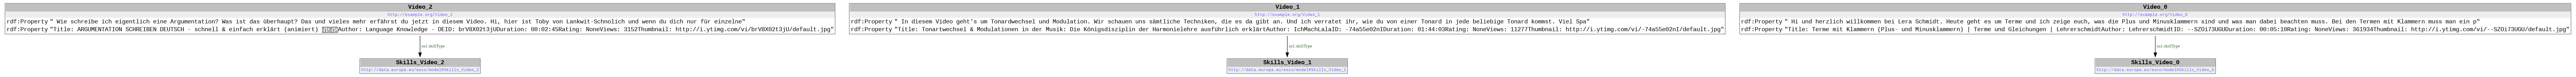

In [ ]:
# plot the graph
def visualize(current_graph):
    stream = io.StringIO()
    rdf2dot(current_graph, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()
    display(Image(png))

visualize(g)

In [ ]:
# download graph & get a better plot!--> https://www.ldf.fi/service/rdf-grapher
g.serialize(destination='example_graph_0.ttl')

<Graph identifier=N9cdf0c6872aa45bab618cb064ab0c70a (<class 'rdflib.graph.Graph'>)>